# Introduction
Here we try to use auto-regressive models like seasonal ARIMA to forecast monthly sales.
In the following analysis per ONE store id is done and data prepared to be able to forecast sales for one store

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf

In [2]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

def plot_series_hist_acf_kpss(Yt: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=Yt, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(Yt, lags=lags)
    plt.show()

    ax = histplot(Yt, bins=hist_bins, kde=True)
    plt.show()

    # Compare median and mean
    print(Yt.describe())

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
    kpss_stat = kpss(Yt, regression='c', store=True)    # hypothesis: constant
    "KPSS={}".format(kpss_stat)# around a mean

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=Yt, lag=lags)
        plt.show()

# Actual vs Fitted
def plot_actual_and_fitted_values(y: Series, model_fit: ARIMAResults):
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = sns.lineplot(data=pd.DataFrame({'actual': y, 'fitted': model_fit.fittedvalues}), ax=axes)
    plt.show()


def errors(y: Series, y_pred: Series):
    return {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred, squared=True)),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MEDIAN_AE': median_absolute_error(y, y_pred),
        'MAX_ABS': y_pred.abs().max(),
        'MIN_ABS': y_pred.abs().min()}


def model_errors(y: Series, model_fit: ARIMAResults):
    fitted:Series = model_fit.fittedvalues[y.index]
    return errors(y, fitted)

# Preprocessing
Feature engineering, create categorial columns

In [3]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})


In [4]:
from pandas.plotting import lag_plot
import seaborn as sns
import matplotlib.pyplot as plt

# Grouped by Store
df_train_stores = df_train.groupby(by=['Store'])
#df_train_stores.Date.max()
#df_train_stores.Date.min()
df_X = df_train_stores.get_group(2).set_index('Date')
sales_zero_idx = df_X[df_X['Sales'] == 0].index
df_X = df_X.drop(sales_zero_idx)
#df_X['2015-01-01':'2015-02-01'].tail(10)
#df_X.head(10)

def avg_sales_per_period(df: DataFrame) -> pd.Series:
    df_copy = df.copy()
    s_tmp: pd.Series = df['Sales'] / df['Open']
    df_copy['Sales_per_open_days_avg'] = s_tmp.astype('int')
    return df_copy
# resample/groupby WEEK
df_weekly_sum: DataFrame = df_X.resample("W").sum()
df_weekly_sum['Year'] = df_weekly_sum.index.year
df_weekly_sum['Week'] = df_weekly_sum.index.week
#df_weekly_sum['Week'] = df_weekly_sum.index.map(lambda week: week.strftime('%m-%d'))
df_weekly_sum = avg_sales_per_period(df_weekly_sum)
#df_weekly_sum = avg_sales_per_promodays(df_weekly_sum)
df_weekly_sum.head(5)

y_t = df_weekly_sum['Sales_per_open_days_avg']



/tmp/ipykernel_297021/3484805081.py:23: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_weekly_sum['Week'] = df_weekly_sum.index.week


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Week,Sales_per_open_days_avg
Date,,,,,,,,,,
2013-01-06,8,18,15407,2103,4,0,3,2013,1,3851
2013-01-13,12,21,32914,3746,6,5,0,2013,2,5485
2013-01-20,12,21,21081,2774,6,0,0,2013,3,3513
2013-01-27,12,21,29973,3415,6,5,0,2013,4,4995
2013-02-03,12,21,23297,3004,6,0,0,2013,5,3882


# Auto-regression | Analysis

Here we try to use auto-regressive analysis to see whether there is a auto-correlation between defined lags

## Seasonal model
A time series is periodic if it repeats itself at equally spaced intervals, say, every 12 months, every 1 week, every 4 months, and so on.
Let us check if our time series has some seasonality element to it.

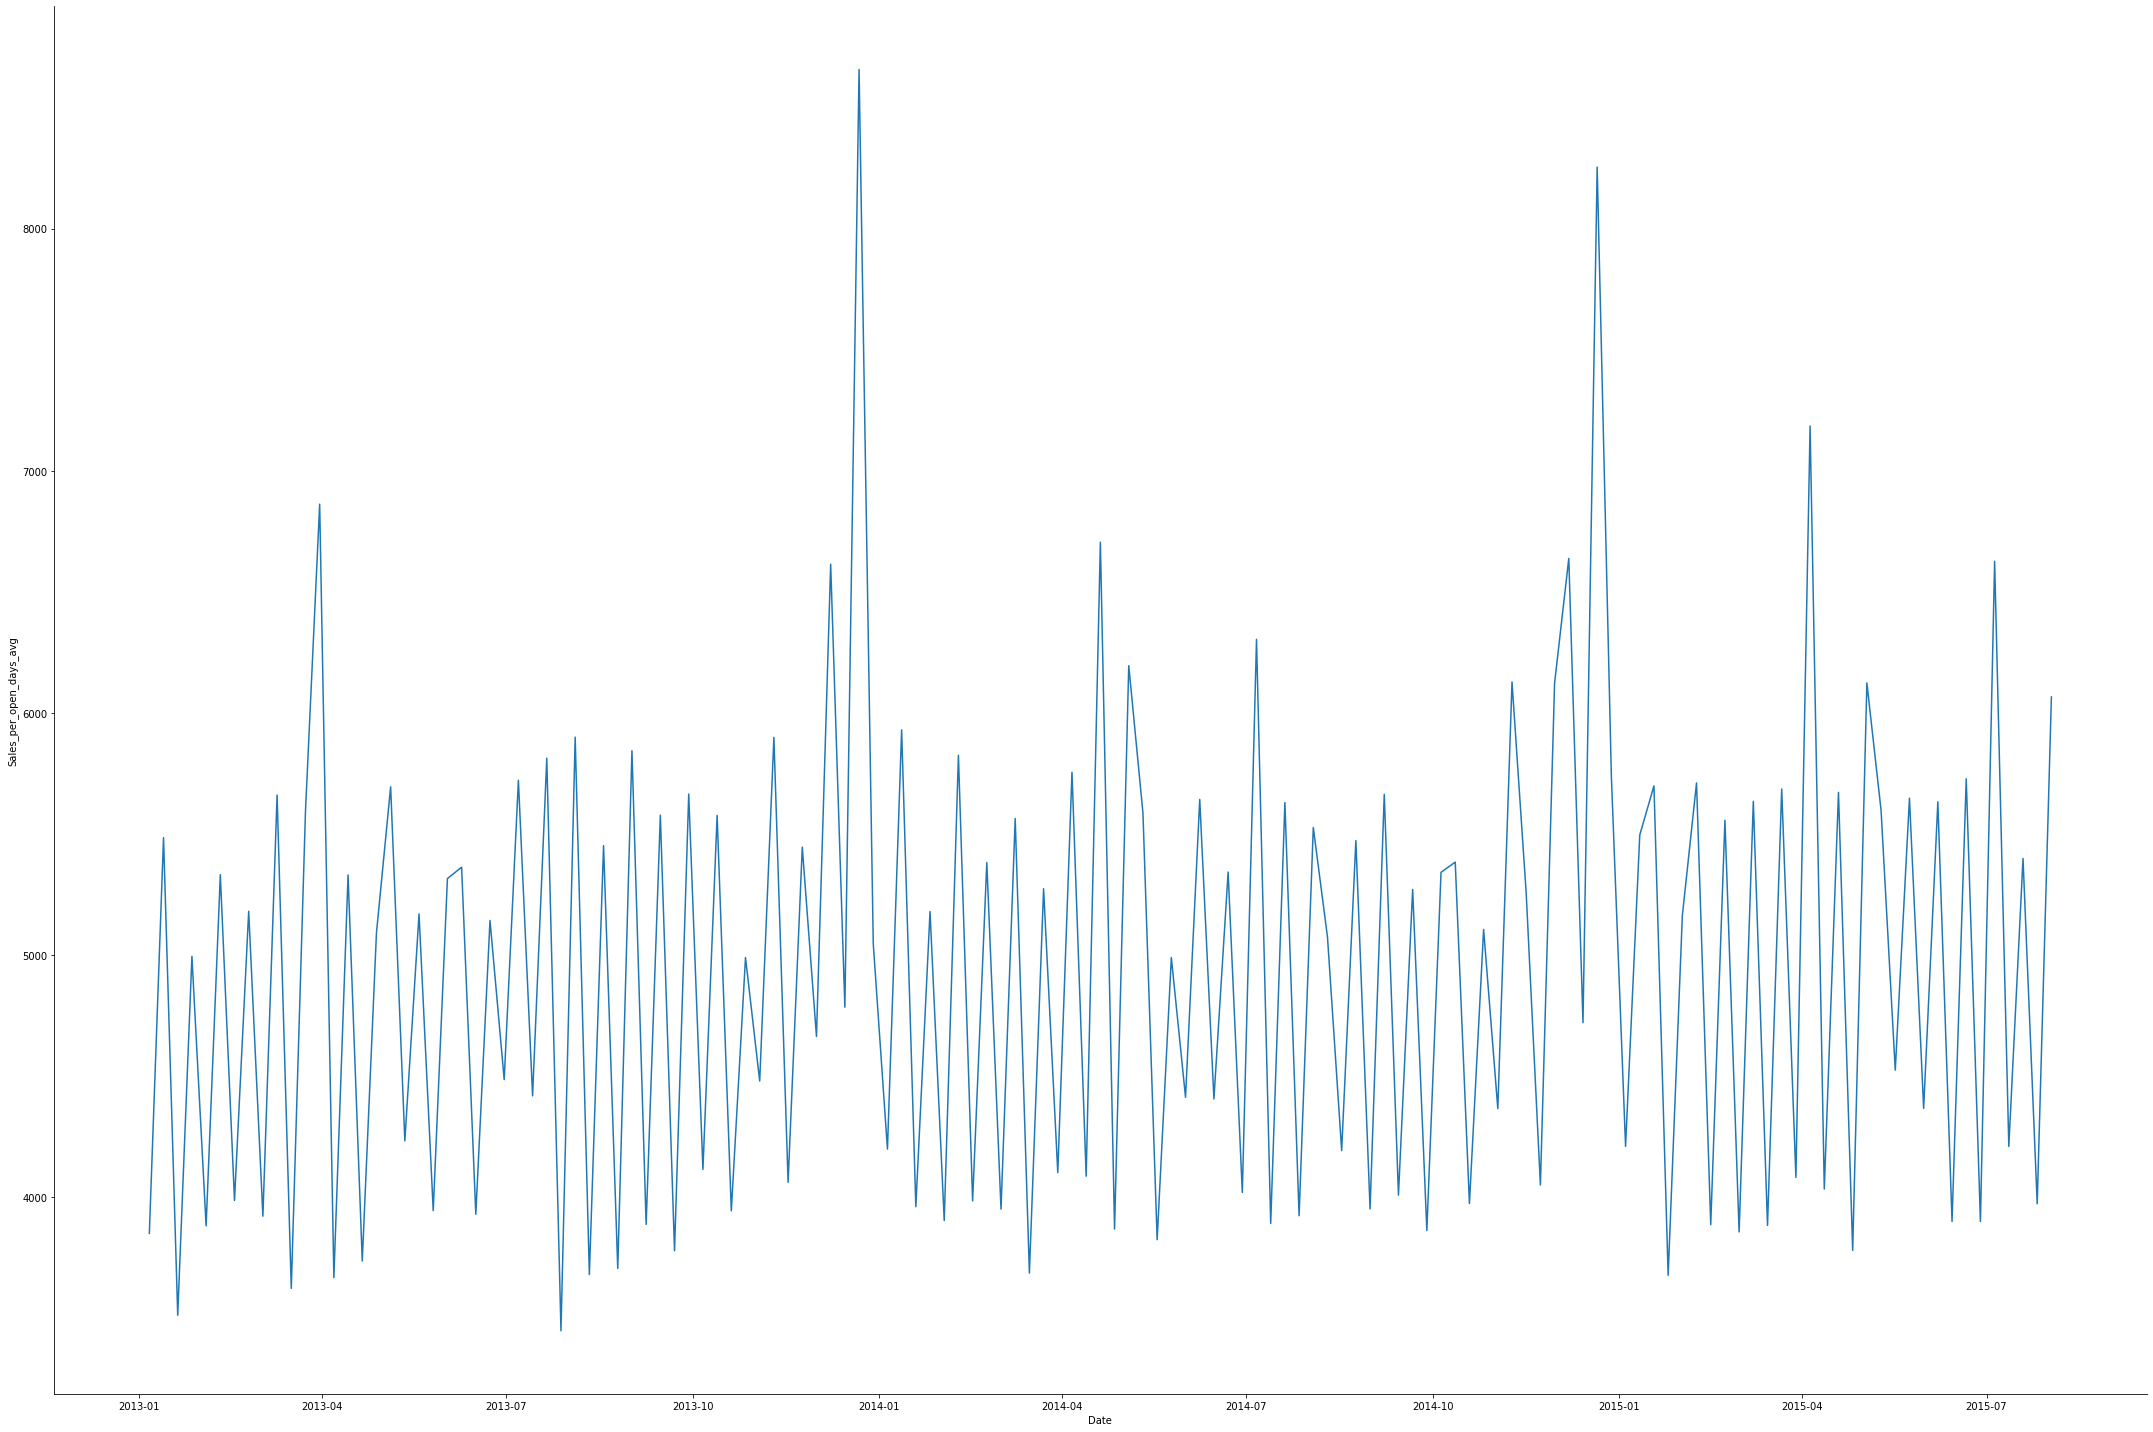

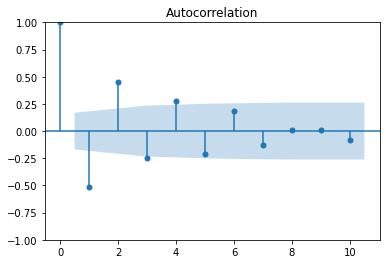

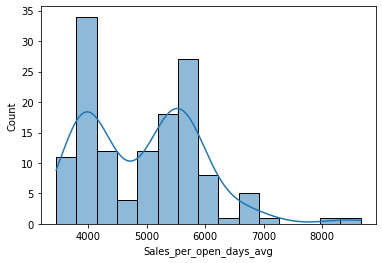

count     135.000000
mean     4953.525926
std       991.336071
min      3449.000000
25%      3979.500000
50%      5106.000000
75%      5639.000000
max      8657.000000
Name: Sales_per_open_days_avg, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


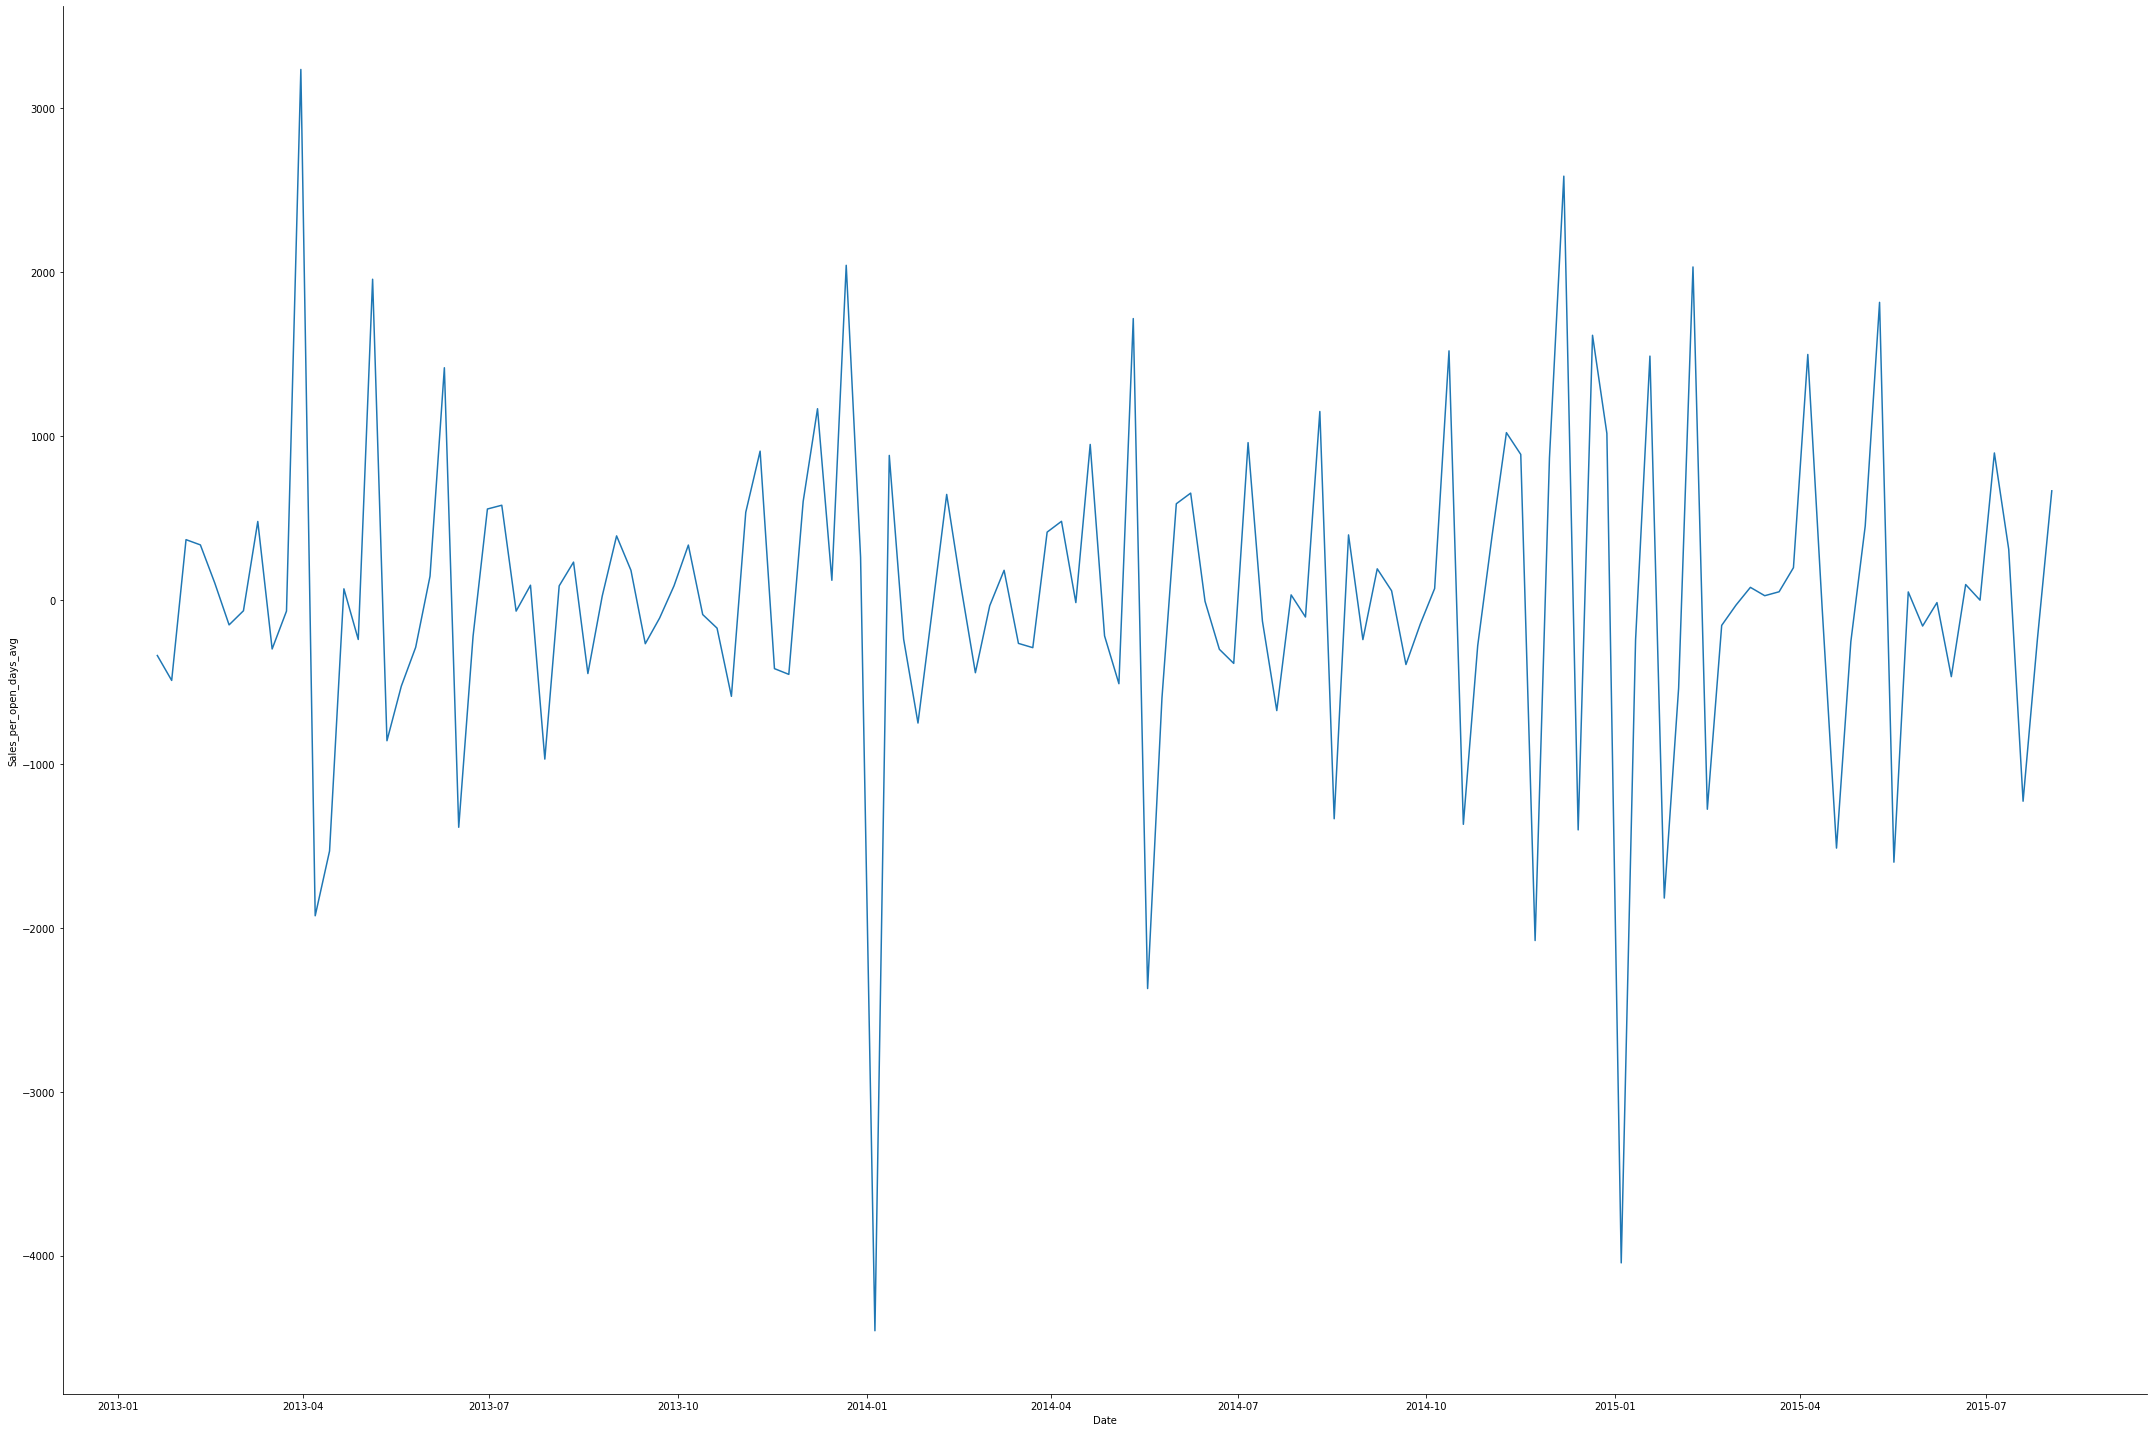

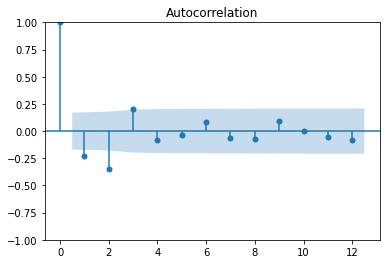

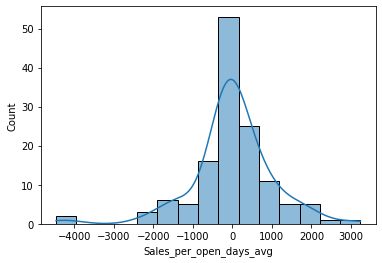

count     133.000000
mean        5.285714
std      1032.389392
min     -4458.000000
25%      -300.000000
50%        -7.000000
75%       452.000000
max      3238.000000
Name: Sales_per_open_days_avg, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


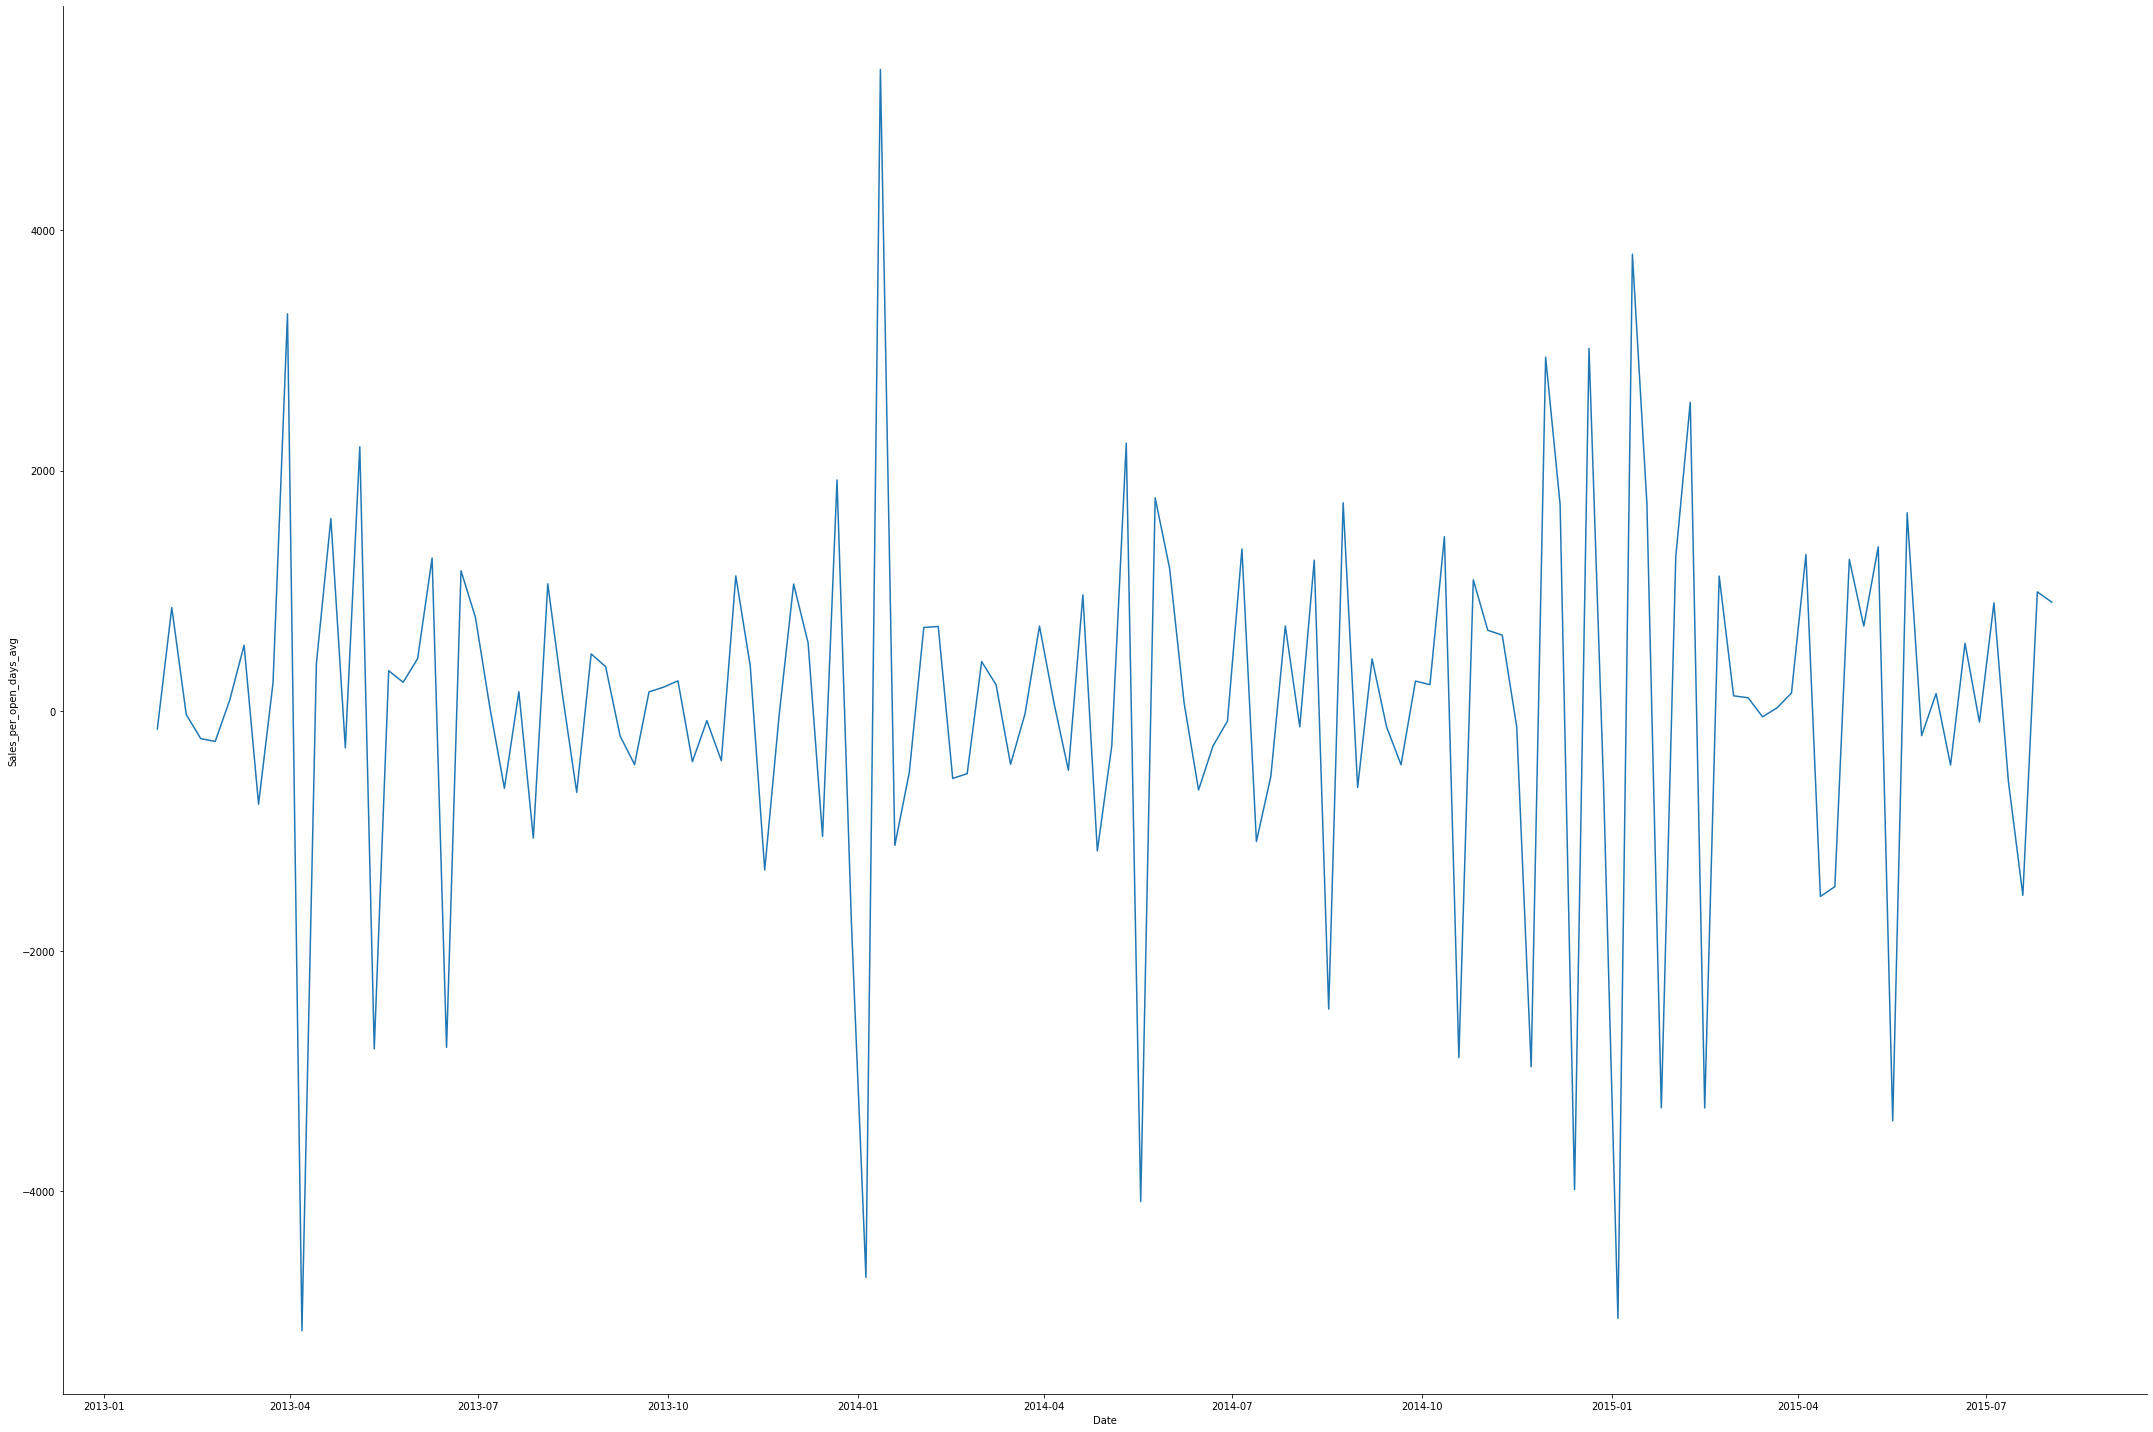

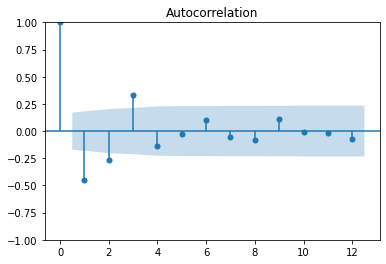

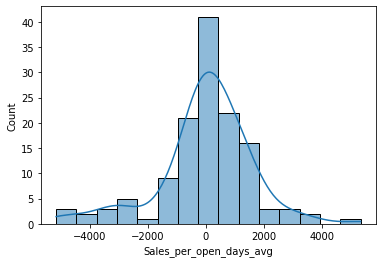

count     132.000000
mean        7.613636
std      1626.517610
min     -5164.000000
25%      -515.000000
50%       133.500000
75%       899.500000
max      5341.000000
Name: Sales_per_open_days_avg, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [5]:
from statsmodels.tsa.statespace.tools import diff

plot_series_hist_acf_kpss(y_t, lags=10)

y_t_diff = diff(series=y_t, k_diff=0, k_seasonal_diff=1, seasonal_periods=2)
plot_series_hist_acf_kpss(y_t_diff, lags=12)

y_t_diff = diff(series=y_t_diff, k_diff=1)
plot_series_hist_acf_kpss(y_t_diff, lags=12)


## Interpretation | Seasonal differencing
The seasonal differenced series seams to be almost stationary cause the mean is near zero and median almost equal.
So we assume to use a seasonal random walk model cause we need no further differencing cause no more lags (non-seasonal or seasonal) are auto correlated. Why, see [here](https://people.duke.edu/~rnau/411searw.htm)

# Forecast | Seasonal random walk with constant
##  Residuals diagnostics
The residuals of the model should be white noise. Difference of fitted vs actual values). if yes model is good, see [here](https://machinelearningmastery.com/white-noise-time-series-python/) and [here](https://otexts.com/fpp3/diagnostics.html) why.


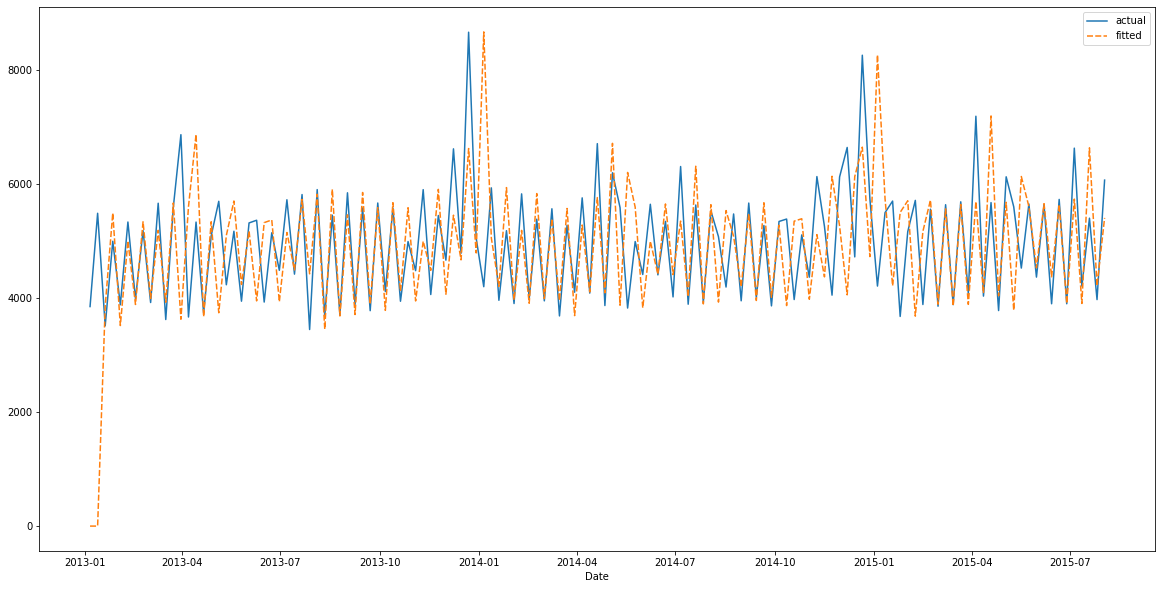

{'RMSE': 1028.5009061036692,
 'MAPE': 0.136210134664234,
 'MAE': 676.9538131041892,
 'MEDIAN_AE': 392.7142857142853,
 'MAX_ABS': 8662.285714285714,
 'MIN_ABS': 3454.2857142857138}

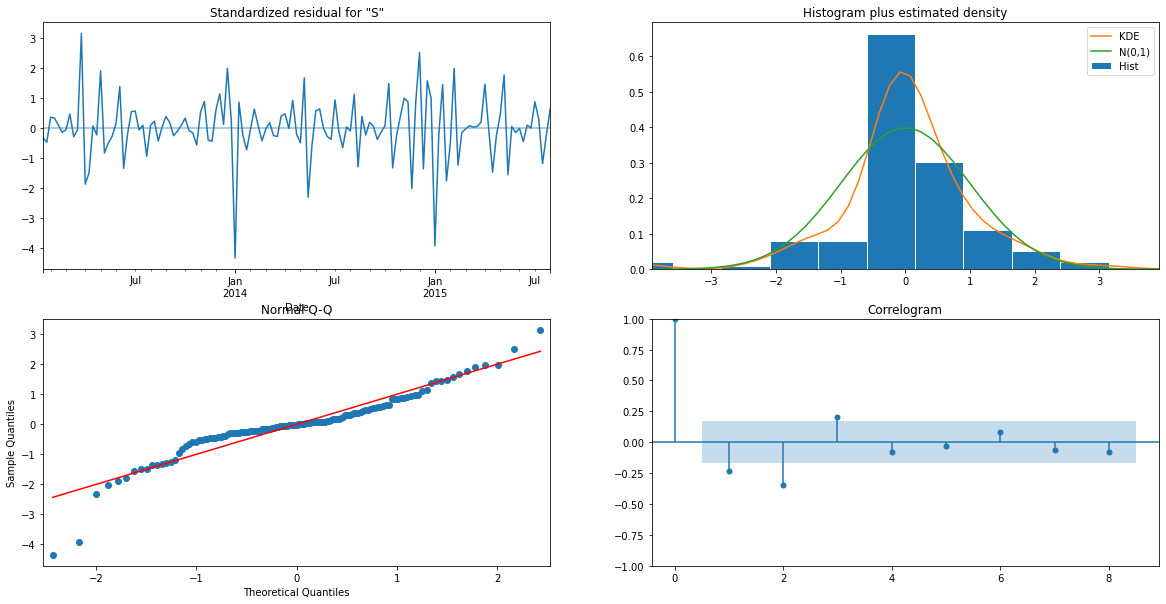

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Sales_per_open_days_avg   No. Observations:                  135
Model:                 SARIMAX(0, 1, 0, 2)   Log Likelihood               -1111.188
Date:                     Fri, 26 Nov 2021   AIC                           2226.376
Time:                             11:31:48   BIC                           2232.156
Sample:                         01-20-2013   HQIC                          2228.725
                              - 08-02-2015                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.2857     93.366      0.057      0.955    -177.708     188.279
sigma2      1.058e+06   7.85e+04     13.481      0.000    9.04e+05    1.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.43   Jarque-Bera (JB):                99.89
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                            -0.72
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
from matplotlib.figure import Figure
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

model: SARIMAX = SARIMAX(y_t, order=(0, 0, 0), seasonal_order=(0, 1, 0, 2), trend='c')
model_fit: ARIMAResults = model.fit(disp=False)

# Plot actual vs fitted values
plot_actual_and_fitted_values(y_t, model_fit)

errors_dict: dict[str, float] = model_errors(y_t.iloc[2:], model_fit)
errors_dict

# Residuals diagnostics
figure: Figure = model_fit.plot_diagnostics(lags=8, figsize=(20, 10))
plt.show()

model_fit.summary(start=2)

# Forecast | Optimization with AR(p)
Cause we have auto correlations in the non-seasonal part use AR(p)


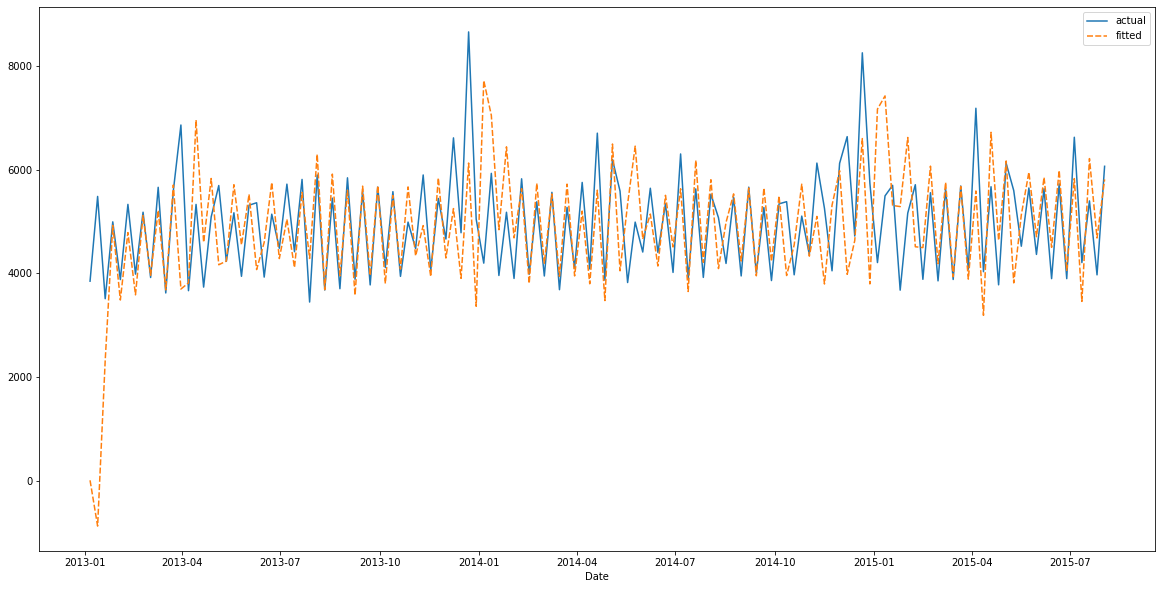

{'RMSE': 947.0440366194296,
 'MAPE': 0.1334757439323,
 'MAE': 667.6988634226991,
 'MEDIAN_AE': 399.76742458564695,
 'MAX_ABS': 7719.595777070079,
 'MIN_ABS': 2319.939964167287}

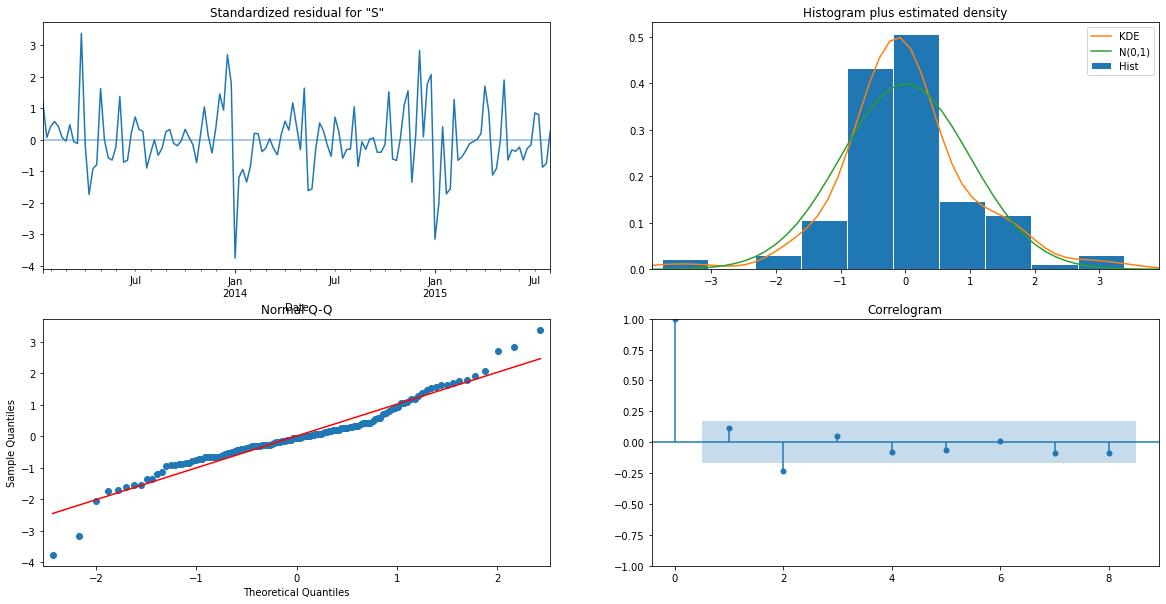

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Sales_per_open_days_avg   No. Observations:                  135
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 2)   Log Likelihood               -1100.220
Date:                            Fri, 26 Nov 2021   AIC                           2206.441
Time:                                    11:31:48   BIC                           2215.112
Sample:                                01-06-2013   HQIC                          2209.964
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|        [1.0        0.0]
------------------------------------------------------------------------------
intercept     11.9903     40.337      0.297      0.766         inf        -inf
ma.L1         -0.5653      0.052    -10.961      0.000         inf        -inf
sigma2       8.78e+05   8.12e+04     10.819      0.000         inf        -inf
===================================================================================
Ljung-Box (L1) (Q):                   1.75   Jarque-Bera (JB):                28.06
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             0.09
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
from matplotlib.figure import Figure
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

model: SARIMAX = SARIMAX(y_t, order=(0, 0, 1), seasonal_order=(0, 1, 0, 2), trend='c')
model_fit: ARIMAResults = model.fit(disp=False)

# Plot actual vs fitted values
plot_actual_and_fitted_values(y_t, model_fit)

# actual vs fitted errors
errors_dict: dict[str, float] = model_errors(y_t.iloc[2:], model_fit)
errors_dict
#"MAE model={}".format(model_fit.mae)

# Residuals diagnostics
figure: Figure = model_fit.plot_diagnostics(lags=8, figsize=(20, 10))
plt.show()

model_fit.summary(2)


# Model accuracy
It is important to evaluate forecast accuracy using genuine forecasts. Consequently, the size of the residuals is not a reliable indication of how large true forecast errors are likely to be. The accuracy of forecasts can only be determined by considering how well a model performs on new data that were not used when fitting the model.
See [here](https://otexts.com/fpp3/accuracy.html) for more info.

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

# 5 train/test sets with 4 test oberservations each
test_size = 4
for y_train_idx, y_test_idx in TimeSeriesSplit(n_splits=5, test_size=test_size).split(y_t):

    y_train = y_t.iloc[y_train_idx]
    y_test  = y_t.iloc[y_test_idx]

    model: SARIMAX = SARIMAX(y_train, order=(0, 1, 2), seasonal_order=(2, 1, 0, 2), trend='c')
    model_fit: ARIMAResults = model.fit()
    y_t_pred = model_fit.forecast(test_size)

    errors(y_test, y_t_pred)


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58361D+00    |proj g|=  8.31908D-01

At iterate    5    f=  8.17592D+00    |proj g|=  2.65401D-02

At iterate   10    f=  8.15874D+00    |proj g|=  4.36541D-03

At iterate   15    f=  8.15844D+00    |proj g|=  1.40503D-03

At iterate   20    f=  8.15592D+00    |proj g|=  8.99931D-04

At iterate   25    f=  8.15553D+00    |proj g|=  3.56344D-04

At iterate   30    f=  8.15517D+00    |proj g|=  1.03531D-02

At iterate   35    f=  8.14015D+00    |proj g|=  7.65127D-02

At iterate   40    f=  8.11938D+00    |proj g|=  1.18034D-02

At iterate   45    f=  8.09313D+00    |proj g|=  1.09248D-01

At iterate   50    f=  8.07849D+00    |proj g|=  2.30936D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

TODOs
1. Interpret AIVC/BIC [here](https://machinelearningmastery.com/probabilistic-model-selection-measures/)
3. Metric for stationarity (KPSS, ADF), see [here](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)